## Dataset-1 (Data Imputation)

In [121]:
# loading required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [122]:
# loading the dataset
data = pd.read_csv('cleaned_datasets/dataset_1.csv')
data.head()

,area_code,area,year_code,year,item_code,item,producer_price_index,area_harvested,production,yield,...,value_added_aff_per_total_fdi,area_code_m49,region,sub_region,european_union_country,least_developed_country,land_locked_developing_country,small_island_developing_state,low_income_food_deficit_country,net_food_importing_developing_country
0,1,Armenia,2001,2001,15,Wheat,74.51,108554.0,241679.0,2226.3,...,6.091945,51,Asia,Western Asia,0.0,0.0,1.0,0.0,0.0,0.0
1,1,Armenia,2002,2002,15,Wheat,64.25,119224.0,284670.0,2387.7,...,3.889558,51,Asia,Western Asia,0.0,0.0,1.0,0.0,0.0,0.0
2,1,Armenia,2003,2003,15,Wheat,86.45,126112.0,216698.0,1718.3,...,2.136457,51,Asia,Western Asia,0.0,0.0,1.0,0.0,0.0,0.0
3,1,Armenia,2004,2004,15,Wheat,89.86,124511.0,291556.0,2341.6,...,2.605379,51,Asia,Western Asia,0.0,0.0,1.0,0.0,0.0,0.0
4,1,Armenia,2005,2005,15,Wheat,66.26,127574.0,258361.0,2025.2,...,2.699758,51,Asia,Western Asia,0.0,0.0,1.0,0.0,0.0,0.0


In [4]:
data.shape

(155474, 106)

In [123]:
# Proportion of missingness by column (sorted in ascending order)
prop_na = data.isna().mean().sort_values(ascending=False)*100
prop_na.head(20)

aoi_credit_to_ag_forest_fish                   32.261986
credit_to_ag_forest_fish_share_total_credit    32.261986
credit_to_ag_forest_fish                       32.261986
govt_expenditure_on_ag_forest_fish             32.141065
gross_production_value                         27.499132
export_quantity                                26.794834
export_value                                   26.717651
afs_employment_share_in_total_employment       25.504586
phosphorus_production                          25.049848
total_credit                                   24.631128
import_quantity                                23.970567
import_value                                   23.950628
total_employment_afs                           23.093894
nitrogen_production                            22.921517
gross_production_index                         14.325225
yield                                          12.410435
area_harvested                                 11.865650
value_added_per_worker         

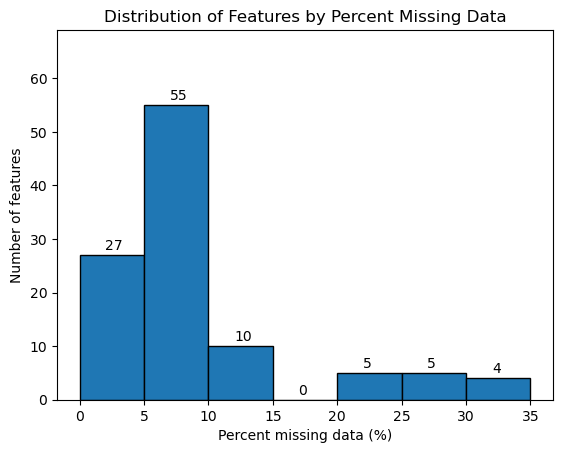

In [ ]:
# Understanding amount of missing data among the features through histogram
plt.figure()
counts, edges, bars = plt.hist(prop_na, edgecolor='black', bins = np.arange(0,40,5))
plt.title('Distribution of Features by Percent Missing Data')
plt.xlabel('Percent missing data (%)')
plt.ylabel('Number of features')
plt.ylim(0,60*1.15)

# adding frequency labels on bars
for count, edge in zip(counts, edges[:-1]):
    plt.text(edge+2, count+1, str(int(count)))

plt.show()

Of the 106 columns, 92 exhibit less than 15% missingness; the remaining 14 fall 
between 20% and 32%. Overall, the missing-data burden is modest and can be 
addressed with robust imputation methods tailored to time-series forecasting. 

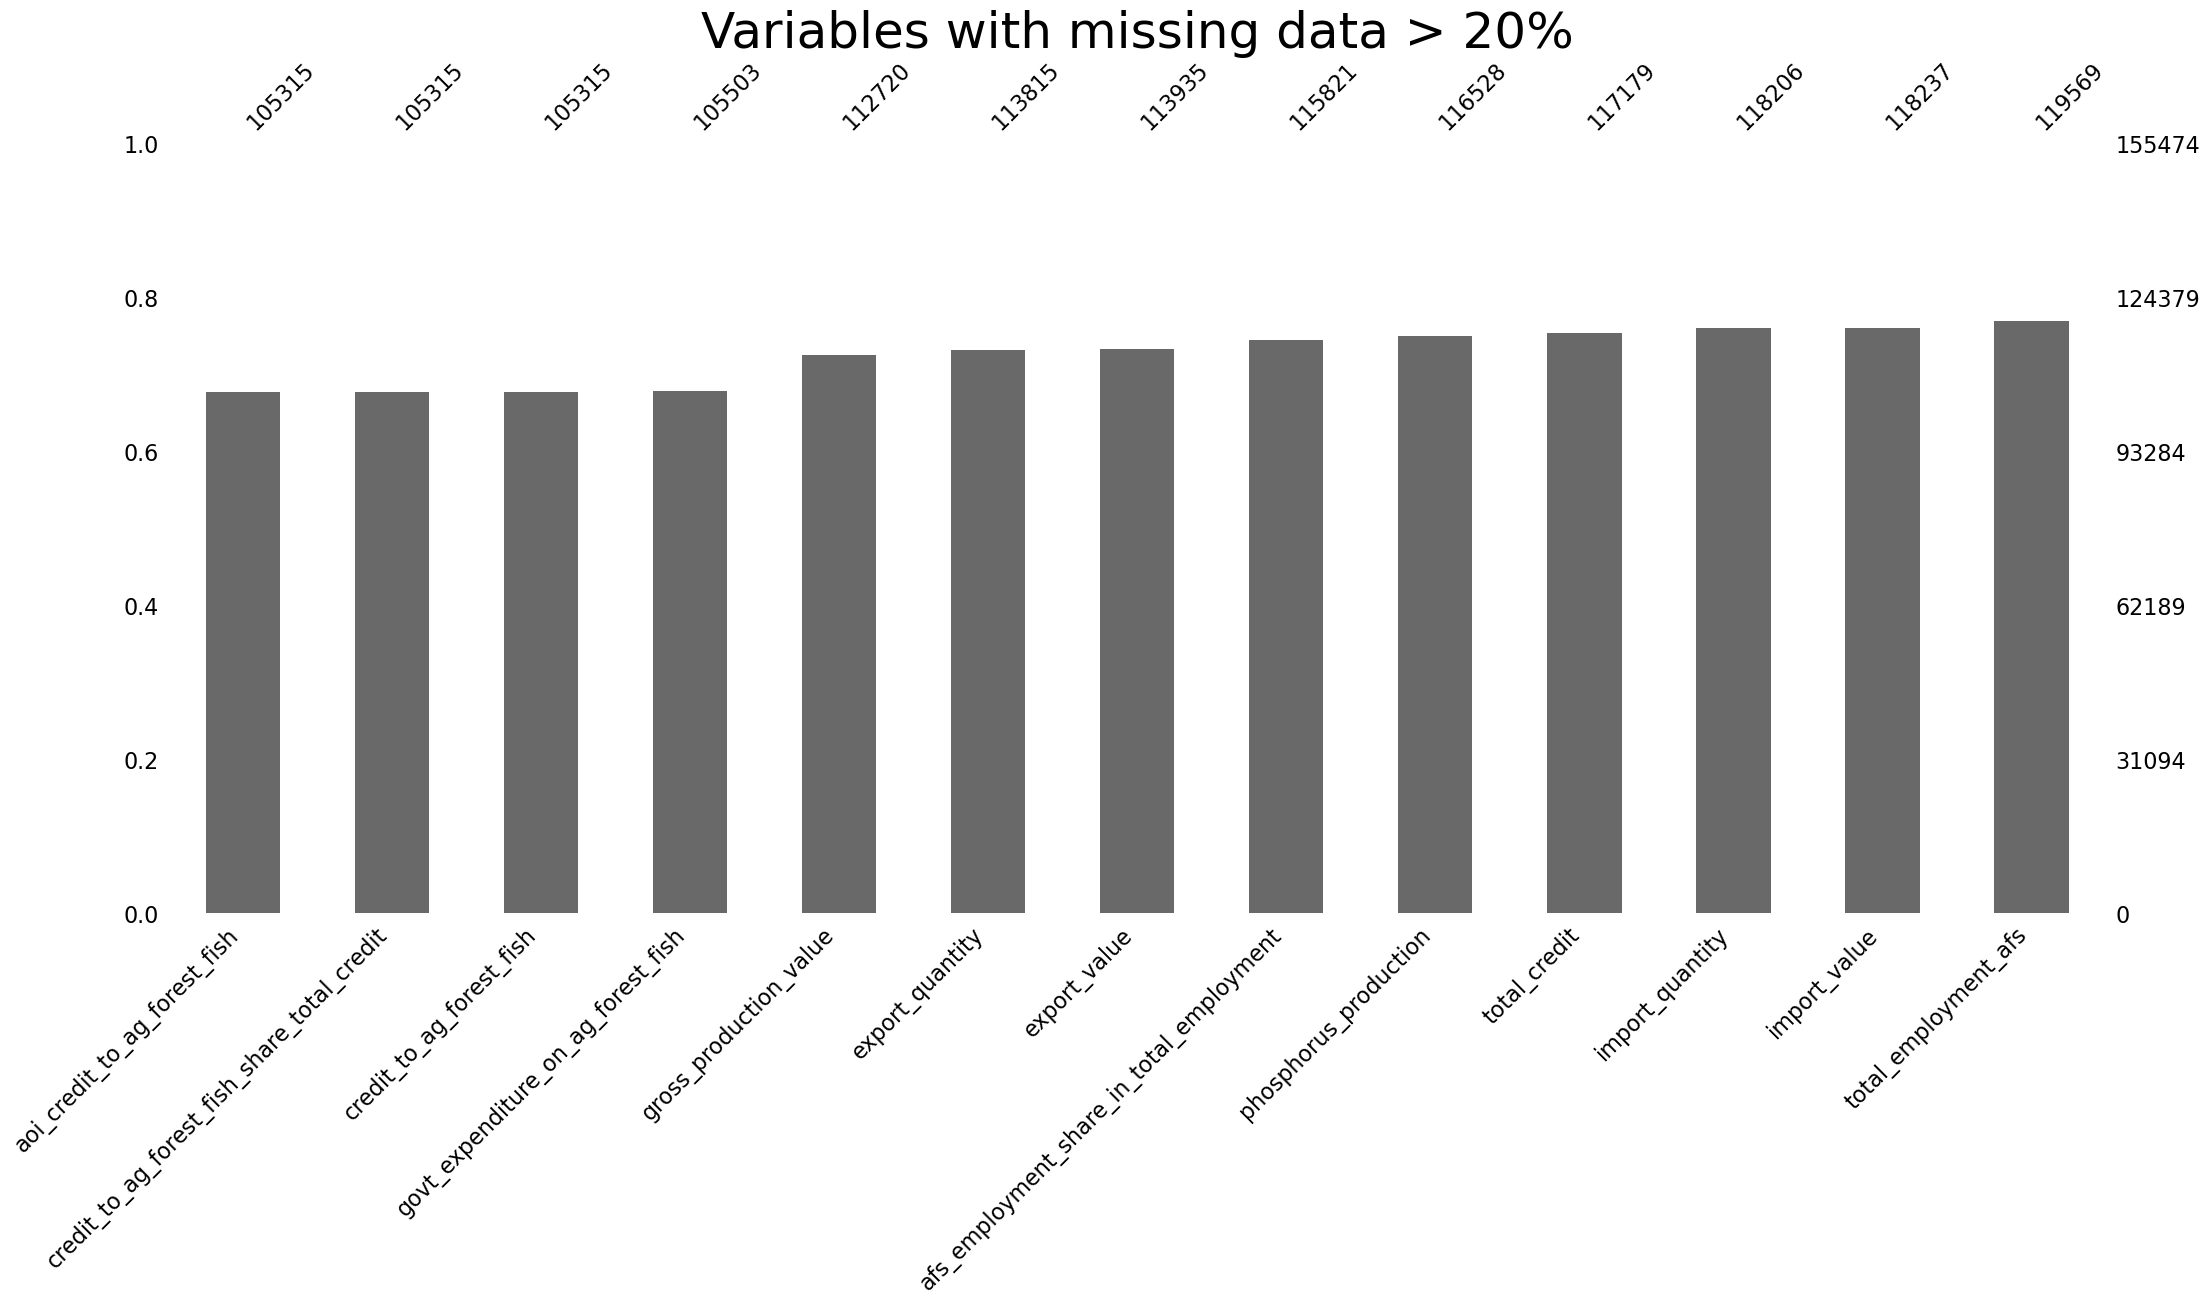

In [ ]:
# Bar plot displaying missingness pattern for the top 13 variables (> 20% NaN)
top_13_missing = prop_na.head(13).index
plt.figure()
miss_plot = msno.bar(data[top_13_missing])
plt.title('Variables with missing data > 20%', fontsize=36)
plt.show()

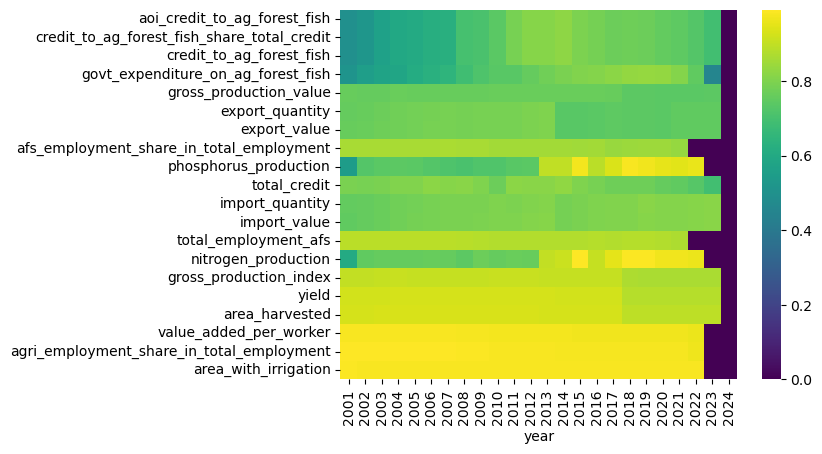

In [ ]:
# Heatmap displaying yearly data coverage (non-missing rate) for each of the top missing variables
top_20_missing = prop_na.head(20).index
coverage_by_year = (
    data.groupby('year')[top_20_missing].apply(lambda x: 1 - x.isna().mean())
)
plt.figure()
miss_heatmap = sns.heatmap(coverage_by_year.T, cmap='viridis')
plt.show()

Because most columns lacked observations in 2024, we removed all 2024 rows from the dataset.

In [124]:
# Filtering rows where year < 2024
df = data.loc[data['year']<2024]
df['year'].nunique()

23

In [125]:
# Proportion of missing data in the target column ('producer_price_index)
print(prop_na['producer_price_index'])

0.33510426180583247


In [126]:
# Number of rows where the target is missing
df.loc[df['producer_price_index'].isna()].shape[0]

521

Of the 155,474 rows, 521 lack the target variable (PPI). These cannot be 
discarded indiscriminately; we first examine missingness within specific 
country–item pairs to identify patterns. Dropping them blindly would disrupt 
time-series continuity and introduce inconsistency. 

## Data Imputation (Country-dependent columns)

Before imputing, we follow two principles:

1. **Scope by dependency:** Impute country-only variables separately from country-item variables, using the appropriate time series (country level vs. country–item level).

2. **Avoid look-ahead bias:** Perform imputation only within the training window (2001–2021), without using future observations to fill past gaps.

We would first impute the country-dependent variables.

In [127]:
# Work on copy of the original dataset
df_1 = df.copy()

In [128]:
# Filter rows where year <= 2021
train_temp_df = df_1.loc[df['year'] <= 2021]
train_temp_df['year'].dtype

dtype('int64')

In [129]:
# columns that depend on both 'area' (country) and 'item' (crop/commodity)
cols_area_and_item_dependent = [
    'export_quantity', 'export_value', 'import_quantity',
    'import_value', 'area_harvested', 'production', 'yield',
    'gross_production_value', 'gross_production_index', 'producer_price_index'
]

# Get all column names from the training dataframe
all_cols = train_temp_df.columns.to_list()

# Derive the list of columns that depend only on 'area' (country) 
# by excluding the area-and-item-dependent columns
cols_area_dependent = list(set(all_cols) - set(cols_area_and_item_dependent))

# Check how many columns are area-dependent
len(cols_area_dependent)

96

In [130]:
# computing the mean 'employment_in_agri' value for each country-year combination
df_area_year = train_temp_df.groupby(['area', 'year'], as_index=False)['employment_in_agri'].mean()

# Count how many years of data are available for each country,
# then display the 20 countries with the fewest records
df_area_year['area'].value_counts().tail(20)

area
Fiji                                21
El Salvador                         21
Estonia                             21
Ethiopia                            21
Maldives                            20
Zambia                              17
Zimbabwe                            17
Serbia                              16
Chad                                15
Timor-Leste                         14
Saint Vincent and the Grenadines    14
Seychelles                          14
Grenada                             12
Angola                              12
Oman                                11
Sierra Leone                        11
Samoa                               10
New Caledonia                        7
Saint Kitts and Nevis                7
Bahrain                              5
Name: count, dtype: int64

While starting on our journey to impute missing data for the country-dpendent variables, 
we notice that for a few countries, data is available for just 5-10 years in the 
training period. 

That entice us to look further into these countries, what is happenening?

In [16]:
train_temp_df.loc[train_temp_df['area']=='Bahrain'][0:20]

,area_code,area,year_code,year,item_code,item,producer_price_index,area_harvested,production,yield,...,value_added_aff_per_total_fdi,area_code_m49,region,sub_region,european_union_country,least_developed_country,land_locked_developing_country,small_island_developing_state,low_income_food_deficit_country,net_food_importing_developing_country
8370,13,Bahrain,2017,2017,116,Potatoes,NaN,2.0,75.0,37500.0,...,0.077209,48,Asia,Western Asia,0.0,0.0,0.0,0.0,0.0,0.0
8371,13,Bahrain,2018,2018,116,Potatoes,NaN,2.0,85.0,42500.0,...,0.070142,48,Asia,Western Asia,0.0,0.0,0.0,0.0,0.0,0.0
8372,13,Bahrain,2019,2019,116,Potatoes,NaN,1.0,30.0,30000.0,...,0.078662,48,Asia,Western Asia,0.0,0.0,0.0,0.0,0.0,0.0
8373,13,Bahrain,2020,2020,116,Potatoes,NaN,1.0,30.0,30000.0,...,0.108859,48,Asia,Western Asia,0.0,0.0,0.0,0.0,0.0,0.0
8374,13,Bahrain,2017,2017,122,Sweet potatoes,NaN,NaN,NaN,NaN,...,0.077209,48,Asia,Western Asia,0.0,0.0,0.0,0.0,0.0,0.0
8375,13,Bahrain,2018,2018,122,Sweet potatoes,NaN,NaN,NaN,NaN,...,0.070142,48,Asia,Western Asia,0.0,0.0,0.0,0.0,0.0,0.0
8376,13,Bahrain,2019,2019,122,Sweet potatoes,NaN,NaN,NaN,NaN,...,0.078662,48,Asia,Western Asia,0.0,0.0,0.0,0.0,0.0,0.0
8377,13,Bahrain,2020,2020,122,Sweet potatoes,NaN,NaN,NaN,NaN,...,0.108859,48,Asia,Western Asia,0.0,0.0,0.0,0.0,0.0,0.0
8378,13,Bahrain,2021,2021,122,Sweet potatoes,NaN,NaN,NaN,NaN,...,0.074112,48,Asia,Western Asia,0.0,0.0,0.0,0.0,0.0,0.0
8379,13,Bahrain,2017,2017,358,Cabbages,NaN,23.0,670.0,29130.4,...,0.077209,48,Asia,Western Asia,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
train_temp_df.loc[
    (train_temp_df['area']=='Bahrain') & (train_temp_df['producer_price_index'].notna())
    ].shape[0]

0

For the country Bahrain, time series starts from 2017 for all the items and the 
response or target variable 'producer_price_index' is missing for all of these 
items throughout the time series. 

Well, thats a problem. We should be dropping this country from our dataset. Because 
imputing the target variable throughout for Bahrain would definitely won't help.

Let's look at some other countries to look for patterns, based on which we would decide 
what to do next.

In [18]:
train_temp_df.loc[train_temp_df['area']=='Saint Kitts and Nevis'][0:15]

,area_code,area,year_code,year,item_code,item,producer_price_index,area_harvested,production,yield,...,value_added_aff_per_total_fdi,area_code_m49,region,sub_region,european_union_country,least_developed_country,land_locked_developing_country,small_island_developing_state,low_income_food_deficit_country,net_food_importing_developing_country
119236,188,Saint Kitts and Nevis,2017,2017,56,Maize (corn),NaN,NaN,NaN,NaN,...,0.158271,659,Americas,Carribean,0.0,0.0,0.0,1.0,0.0,1.0
119237,188,Saint Kitts and Nevis,2018,2018,56,Maize (corn),NaN,NaN,NaN,NaN,...,0.186339,659,Americas,Carribean,0.0,0.0,0.0,1.0,0.0,1.0
119238,188,Saint Kitts and Nevis,2019,2019,56,Maize (corn),NaN,NaN,NaN,NaN,...,0.188554,659,Americas,Carribean,0.0,0.0,0.0,1.0,0.0,1.0
119239,188,Saint Kitts and Nevis,2015,2015,122,Sweet potatoes,84.02,23.0,128.0,5565.2,...,0.061938,659,Americas,Carribean,0.0,0.0,0.0,1.0,0.0,1.0
119240,188,Saint Kitts and Nevis,2016,2016,122,Sweet potatoes,115.98,29.0,182.0,6377.1,...,0.057541,659,Americas,Carribean,0.0,0.0,0.0,1.0,0.0,1.0
119241,188,Saint Kitts and Nevis,2017,2017,122,Sweet potatoes,112.02,25.0,172.0,6989.7,...,0.158271,659,Americas,Carribean,0.0,0.0,0.0,1.0,0.0,1.0
119242,188,Saint Kitts and Nevis,2018,2018,122,Sweet potatoes,112.02,22.0,149.0,6825.1,...,0.186339,659,Americas,Carribean,0.0,0.0,0.0,1.0,0.0,1.0
119243,188,Saint Kitts and Nevis,2019,2019,122,Sweet potatoes,112.02,46.0,305.5,6690.2,...,0.188554,659,Americas,Carribean,0.0,0.0,0.0,1.0,0.0,1.0
119244,188,Saint Kitts and Nevis,2020,2020,122,Sweet potatoes,111.32,25.0,159.6,6323.6,...,-15.845493,659,Americas,Carribean,0.0,0.0,0.0,1.0,0.0,1.0
119245,188,Saint Kitts and Nevis,2021,2021,122,Sweet potatoes,111.78,29.0,175.5,5964.1,...,0.338003,659,Americas,Carribean,0.0,0.0,0.0,1.0,0.0,1.0


For the country 'Saint Kitts and Nevis', there is no item related data for the 'Maize' 
crop. Other items look fine.

In [19]:
train_temp_df.loc[train_temp_df['area']=='New Caledonia'][0:20]

,area_code,area,year_code,year,item_code,item,producer_price_index,area_harvested,production,yield,...,value_added_aff_per_total_fdi,area_code_m49,region,sub_region,european_union_country,least_developed_country,land_locked_developing_country,small_island_developing_state,low_income_food_deficit_country,net_food_importing_developing_country
97546,153,New Caledonia,2018,2018,15,Wheat,NaN,8.0,4.4,522.4,...,0.739198,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
97547,153,New Caledonia,2019,2019,15,Wheat,NaN,184.0,109.0,592.8,...,0.376074,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
97548,153,New Caledonia,2020,2020,15,Wheat,NaN,105.0,53.6,509.4,...,0.538395,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
97549,153,New Caledonia,2021,2021,15,Wheat,NaN,150.0,84.5,561.8,...,0.467417,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
97551,153,New Caledonia,2018,2018,27,Rice,NaN,NaN,NaN,NaN,...,0.739198,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
97552,153,New Caledonia,2019,2019,27,Rice,NaN,NaN,NaN,NaN,...,0.376074,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
97553,153,New Caledonia,2016,2016,56,Maize (corn),100.00,1016.0,8543.0,8408.5,...,0.348583,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
97554,153,New Caledonia,2017,2017,56,Maize (corn),99.99,1045.0,9415.2,9009.8,...,0.445259,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
97555,153,New Caledonia,2018,2018,56,Maize (corn),99.99,1109.0,10184.0,9183.5,...,0.739198,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
97556,153,New Caledonia,2019,2019,56,Maize (corn),100.01,964.0,8842.0,9169.6,...,0.376074,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0


Similarly, for the country 'New Caledonia', there are a few items like wheat, rice, 
and sorghum for which we are missing response variable data and interestingly, 
for sorghum there is just one instance which is the year 2018. 

In [20]:
train_temp_df.loc[train_temp_df['area']=='Samoa'][40:60]

,area_code,area,year_code,year,item_code,item,producer_price_index,area_harvested,production,yield,...,value_added_aff_per_total_fdi,area_code_m49,region,sub_region,european_union_country,least_developed_country,land_locked_developing_country,small_island_developing_state,low_income_food_deficit_country,net_food_importing_developing_country
150181,244,Samoa,2012,2012,497,Lemons and limes,91.32,NaN,NaN,NaN,...,3.401699,882,Oceania,Polynesia,0.0,0.0,0.0,1.0,0.0,1.0
150182,244,Samoa,2013,2013,497,Lemons and limes,88.35,NaN,NaN,NaN,...,5.133535,882,Oceania,Polynesia,0.0,0.0,0.0,1.0,0.0,1.0
150183,244,Samoa,2014,2014,497,Lemons and limes,78.30,NaN,NaN,NaN,...,3.152236,882,Oceania,Polynesia,0.0,0.0,0.0,1.0,0.0,1.0
150184,244,Samoa,2015,2015,497,Lemons and limes,134.33,NaN,NaN,NaN,...,2.604457,882,Oceania,Polynesia,0.0,0.0,0.0,1.0,0.0,1.0
150185,244,Samoa,2016,2016,497,Lemons and limes,87.37,NaN,NaN,NaN,...,29.621512,882,Oceania,Polynesia,0.0,0.0,0.0,1.0,0.0,1.0
150186,244,Samoa,2017,2017,497,Lemons and limes,466.75,NaN,NaN,NaN,...,9.077860,882,Oceania,Polynesia,0.0,0.0,0.0,1.0,0.0,1.0
150187,244,Samoa,2018,2018,497,Lemons and limes,522.64,NaN,NaN,NaN,...,4.251227,882,Oceania,Polynesia,0.0,0.0,0.0,1.0,0.0,1.0
150188,244,Samoa,2019,2019,497,Lemons and limes,660.80,NaN,NaN,NaN,...,-16.347227,882,Oceania,Polynesia,0.0,0.0,0.0,1.0,0.0,1.0
150189,244,Samoa,2020,2020,497,Lemons and limes,603.87,NaN,NaN,NaN,...,16.115577,882,Oceania,Polynesia,0.0,0.0,0.0,1.0,0.0,1.0
150190,244,Samoa,2021,2021,497,Lemons and limes,584.53,NaN,NaN,NaN,...,8.081359,882,Oceania,Polynesia,0.0,0.0,0.0,1.0,0.0,1.0


In [21]:
train_temp_df.loc[train_temp_df['area']=='Sierra Leone'][0:15]

,area_code,area,year_code,year,item_code,item,producer_price_index,area_harvested,production,yield,...,value_added_aff_per_total_fdi,area_code_m49,region,sub_region,european_union_country,least_developed_country,land_locked_developing_country,small_island_developing_state,low_income_food_deficit_country,net_food_importing_developing_country
121276,197,Sierra Leone,2011,2011,27,Rice,65.72,603924.0,1129338.00,1870.0,...,1.855552,694,Africa,Western Africa,0.0,1.0,0.0,0.0,1.0,1.0
121277,197,Sierra Leone,2012,2012,27,Rice,65.72,717872.0,1141417.00,1590.0,...,2.843726,694,Africa,Western Africa,0.0,1.0,0.0,0.0,1.0,1.0
121278,197,Sierra Leone,2013,2013,27,Rice,87.63,671422.0,1255559.00,1870.0,...,5.359653,694,Africa,Western Africa,0.0,1.0,0.0,0.0,1.0,1.0
121279,197,Sierra Leone,2014,2014,27,Rice,87.63,741664.0,1204020.00,1623.4,...,6.033039,694,Africa,Western Africa,0.0,1.0,0.0,0.0,1.0,1.0
121280,197,Sierra Leone,2015,2015,27,Rice,87.63,604930.0,871693.00,1441.0,...,9.887634,694,Africa,Western Africa,0.0,1.0,0.0,0.0,1.0,1.0
121281,197,Sierra Leone,2016,2016,27,Rice,124.74,765335.0,875304.00,1143.7,...,16.008824,694,Africa,Western Africa,0.0,1.0,0.0,0.0,1.0,1.0
121282,197,Sierra Leone,2017,2017,27,Rice,123.23,780642.0,897087.00,1149.2,...,5.223859,694,Africa,Western Africa,0.0,1.0,0.0,0.0,1.0,1.0
121283,197,Sierra Leone,2018,2018,27,Rice,123.56,1169418.0,918713.00,785.6,...,9.467657,694,Africa,Western Africa,0.0,1.0,0.0,0.0,1.0,1.0
121284,197,Sierra Leone,2019,2019,27,Rice,135.77,601748.0,947464.00,1574.5,...,6.923059,694,Africa,Western Africa,0.0,1.0,0.0,0.0,1.0,1.0
121285,197,Sierra Leone,2020,2020,27,Rice,150.84,604407.0,1049795.00,1736.9,...,14.182201,694,Africa,Western Africa,0.0,1.0,0.0,0.0,1.0,1.0


For the countries like 'Samoa' and 'Sierra Leone', the time series starts at the 
year 2012 and 2011 respectively, but the time series mostly look complete.

So, we have found some interesting patterns in the data availability and missingness 
for certain country-item pairs. We decided to remove those country-item pairs 
that are:

1. missing target variable (producer_price_index) data completely for the series.
2. missing target variable data for >50% of the time series.
3. missing item-related data from the variables- 'area_harvested', 'production', 'yield' for >50% of the time series.
4. missing data for the target variable during the either 1 or both of the years from 2022 to 2023.
5. having no instance for the years 2022 and 2023. 

In [132]:
df.shape

(148889, 106)

In [133]:
# Create a DataFrame containing unique (area, item) pairs
unique_pairs = df[['area', 'item']].drop_duplicates().reset_index(drop=True)
unique_pairs.head()

,area,item
0,Armenia,Wheat
1,Armenia,Barley
2,Armenia,Maize (corn)
3,Armenia,Rye
4,Armenia,Oats


In [134]:
# Count total number of unique country-item pairs in the dataset
unique_pairs.shape[0]

6753

In [135]:
unique_pairs.to_numpy()[0:5]

array([['Armenia', 'Wheat'],
       ['Armenia', 'Barley'],
       ['Armenia', 'Maize (corn)'],
       ['Armenia', 'Rye'],
       ['Armenia', 'Oats']], dtype=object)

In [136]:
"""
Long Approach for creating list of unique pairs:

unique_pairs_list = []
for idx in range(unique_pairs.shape[0]):
    pair = (unique_pairs.iloc[idx]['area'], unique_pairs.iloc[idx]['item'])
    unique_pairs_list.append(pair)

unique_pairs_list
"""

# Convert each row of the DataFrame `unique_pairs` into a tuple,
# then store all tuples in a Python list.
# This is useful for iterating, or using the pairs as keys in dictionaries/sets.
unique_pairs_list = [tuple(x) for x in unique_pairs.to_numpy()]
unique_pairs_list[0:5]

[('Armenia', 'Wheat'),
 ('Armenia', 'Barley'),
 ('Armenia', 'Maize (corn)'),
 ('Armenia', 'Rye'),
 ('Armenia', 'Oats')]

In [137]:
"""
IMPORTANT:
Setting the ['area', 'item'] as index and then sorting the index greatly reduces 
the look-up time (by multiple folds) in the for loop.
"""

# Set a multi-index on the DataFrame using 'area' and 'item' columns and sort for efficient lookup
df_indexed = df.set_index(['area', 'item']).sort_index()

# Initialize empty lists to store (area, item) pairs where all producer_price_index values are NaN
pairs_all_NaN = []

# Initialize empty lists to store (area, item) pairs where >50% but < 100% producer_price_index values 
# are NaN
pairs_gt_50_NaN_PPI = []

# Initialize empty lists to store (area, item) pairs where >50% NaN in production, yield, or area_harvested 
pairs_gt_50_NaN_others = []

# Initialize empty lists to store (area, item) pairs where PPI is NaN for either or both of the years 2022 and 2023
pairs_NaN_2022_2023 = []

# Initialize empty lists to store (area, item) pairs where the series is missing instance for both years 2022 and 2023.
pairs_missing_instance_2022_2023 = []

# Iterate over each unique (area, item) pair from the provided list
for area, item in unique_pairs_list:
    # Extract the subset of the DataFrame for the current (area, item) pair and reset index for analysis
    series = df_indexed.loc[(area, item)].reset_index()

    # Calculate the proportion of NaN values for each column of interest
    nan_PPI_ratio = series['producer_price_index'].isna().sum() / series.shape[0]
    nan_production_ratio = series['production'].isna().sum() / series.shape[0]
    nan_yield_ratio = series['yield'].isna().sum() / series.shape[0]
    nan_area_harvested_ratio = series['area_harvested'].isna().sum() / series.shape[0]

    # Identify rows where year is 2022 or 2023 and producer_price_index is NaN
    nan_PPI_2022_2023 = (series['year'].isin([2022, 2023])) & (series['producer_price_index'].isna())

    # Check if all values in producer_price_index are NaN (100% NaN)
    if series['producer_price_index'].isna().all():
        pairs_all_NaN.append((area, item))

    # Check if producer_price_index has >50% NaN but not 100% NaN
    if (nan_PPI_ratio > 0.5) & (nan_PPI_ratio < 1.0):
        pairs_gt_50_NaN_PPI.append((area, item))

    # Check if any of production, yield, or area_harvested has >50% NaN
    if (nan_production_ratio > 0.5) | (nan_yield_ratio > 0.5) | (nan_area_harvested_ratio > 0.5):
        pairs_gt_50_NaN_others.append((area, item))

    # Check if any rows for 2022 or 2023 have NaN in producer_price_index
    if nan_PPI_2022_2023.any():
        pairs_NaN_2022_2023.append((area, item))

    # Check if 2022 is present in the list of years
    if (2022 not in series['year'].to_list()) & (2023 not in series['year'].to_list()):
        pairs_missing_instance_2022_2023.append((area, item))


# Print the count of pairs meeting each NaN criterion
print(f"Number of country-item pairs with all NaN for PPI: {len(pairs_all_NaN)}") 
print(f"Number of country-item pairs with >50% but <100% NaN for PPI: {len(pairs_gt_50_NaN_PPI)}") 
print(f"Number of country-item pairs with >50% NaN for other item-related columns: {len(pairs_gt_50_NaN_others)}") 
print(f"Number of country-item pairs with NaN for PPI for 2022 or 2023: {len(pairs_NaN_2022_2023)}") 
print(f"Number of country-item pairs with missing instance for 2022 and 2023: {len(pairs_missing_instance_2022_2023)}") 

Number of country-item pairs with all NaN for PPI: 109
Number of country-item pairs with >50% but <100% NaN for PPI: 0
Number of country-item pairs with >50% NaN for other item-related columns: 518
Number of country-item pairs with NaN for PPI for 2022 or 2023: 79
Number of country-item pairs with missing instance for 2022 and 2023: 67


In [138]:
# Combine the three lists of (area, item) pairs into a single list
total_pairs = pairs_all_NaN + pairs_gt_50_NaN_PPI + pairs_gt_50_NaN_others + \
    pairs_NaN_2022_2023 + pairs_missing_instance_2022_2023

# Remove duplicates by converting to a set and back to a list
pairs_to_drop = list(set(total_pairs))

# Calculate the number of unique (area, item) pairs
len(pairs_to_drop)

630

In [139]:
# Filter out rows where the index (area, item pairs) matches entries in pairs_to_drop
df = df.set_index(['area', 'item']).sort_index()
df_filtered = df.loc[~df.index.isin(pairs_to_drop)]
df_filtered = df_filtered.reset_index() # to make 'area' and 'item' regular columns again
df_filtered.shape

(137356, 106)

In [736]:
df_filtered.to_csv('cleaned_datasets/dataset_1_filtered.csv', index = False)

So, we end up removing 630 country-item pairs from a total of 6753 which did not 
meet our criteria, i.e., they were missing data related to our target variable 
PPI or other item-related variables. 

In [140]:
df_filtered['producer_price_index'].isna().sum()

np.int64(0)

In [20]:
df_filtered['area'].nunique()

147

In [32]:
df_filtered['item'].nunique()

130

Now, we end up with having 147 countries and 130 items in our dataset. There are 
total 137356 total rows in the dataset.

In [288]:
# Work on the copy of filtered dataset
df_2 = df_filtered.copy()

In [289]:
df_2.loc[df_2['area']=='New Caledonia'][0:20]

,area,item,area_code,year_code,year,item_code,producer_price_index,area_harvested,production,yield,...,value_added_aff_per_total_fdi,area_code_m49,region,sub_region,european_union_country,least_developed_country,land_locked_developing_country,small_island_developing_state,low_income_food_deficit_country,net_food_importing_developing_country
88162,New Caledonia,"Cassava, fresh",153,2015,2015,125,99.23,337.0,875.70,2601.5,...,0.154575,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
88163,New Caledonia,"Cassava, fresh",153,2016,2016,125,100.77,270.0,751.80,2784.1,...,0.348583,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
88164,New Caledonia,"Cassava, fresh",153,2017,2017,125,104.47,280.0,816.50,2917.7,...,0.445259,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
88165,New Caledonia,"Cassava, fresh",153,2018,2018,125,119.07,270.0,812.90,3009.7,...,0.739198,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
88166,New Caledonia,"Cassava, fresh",153,2019,2019,125,87.56,270.0,831.80,3083.2,...,0.376074,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
88167,New Caledonia,"Cassava, fresh",153,2020,2020,125,71.52,259.0,812.90,3141.0,...,0.538395,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
88168,New Caledonia,"Cassava, fresh",153,2021,2021,125,179.82,247.0,802.10,3247.9,...,0.467417,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
88169,New Caledonia,"Cassava, fresh",153,2022,2022,125,36.27,237.0,795.00,3347.8,...,0.542556,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
88170,New Caledonia,"Cassava, fresh",153,2023,2023,125,99.77,202.0,696.65,3447.6,...,0.590195,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0
88171,New Caledonia,"Coconuts, in shell",153,2015,2015,249,90.90,2455.0,18000.00,7333.4,...,0.154575,540,Oceania,Melanesia,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Creating training subset (year <= 2021)
#train_temp_df_2 = df_2.loc[df_2['year'] <= 2021]
#train_temp_df_2['year'].dtype

dtype('int64')

In [290]:
# Define numeric columns that depend on both 'area' (country) and 'item' (commodity)
cols_area_and_item_dependent = [
    'export_quantity', 'export_value', 'import_quantity',
    'import_value', 'area_harvested', 'production', 'yield',
    'gross_production_value', 'gross_production_index', 'producer_price_index'
]

# Get the list of all column names from the training set
all_cols = df_2.columns.to_list()

# Identify categorical or binary columns
cols_categorical_binary = []
for col in all_cols:
    if df_2[col].dtype.name == 'object':
        cols_categorical_binary.append(col)
    else:
        unique_values = df_2[col].nunique()
        if unique_values == 2:
            cols_categorical_binary.append(col)

# List of other columns considered irrelevant for area-only imputation
other_irrelevant_cols = ['item_code', 'year_code', 'year', 'area_code', 'area_code_m49']

# Derive columns that depend only on 'area' (country)  
# by excluding:
#   - area+item dependent variables
#   - categorical/binary variables
#   - irrelevant metadata columns
cols_area_dependent = list(set(all_cols) - set(cols_area_and_item_dependent + cols_categorical_binary + other_irrelevant_cols))

# Output the number of columns that are area-dependent
len(cols_area_dependent)

81

Our imputation strategy should be tailored to each variable’s distribution and 
temporal pattern. When a variable’s time series is approximately constant or linear, 
simple methods—such as linear or spline interpolation may suffice. In contrast, 
if the series exhibits abrupt or random spikes, these simpler approaches are 
likely inadequate. In those cases, more advanced, model-based methods 
(e.g., machine-learning imputation) are warranted to leverage both 
(i) cross-sectional information from related variables (“horizontal” signals) and 
(ii) the variable’s own temporal structure (“vertical” signals). 

Additionally, when variables show similar trends across countries within the same 
region or sub-region, information from one country can be used to impute missing values in another. 
These patterns are best diagnosed visually, so we will first plot the 
country-level variables (independent of item) and explore the data to guide method selection

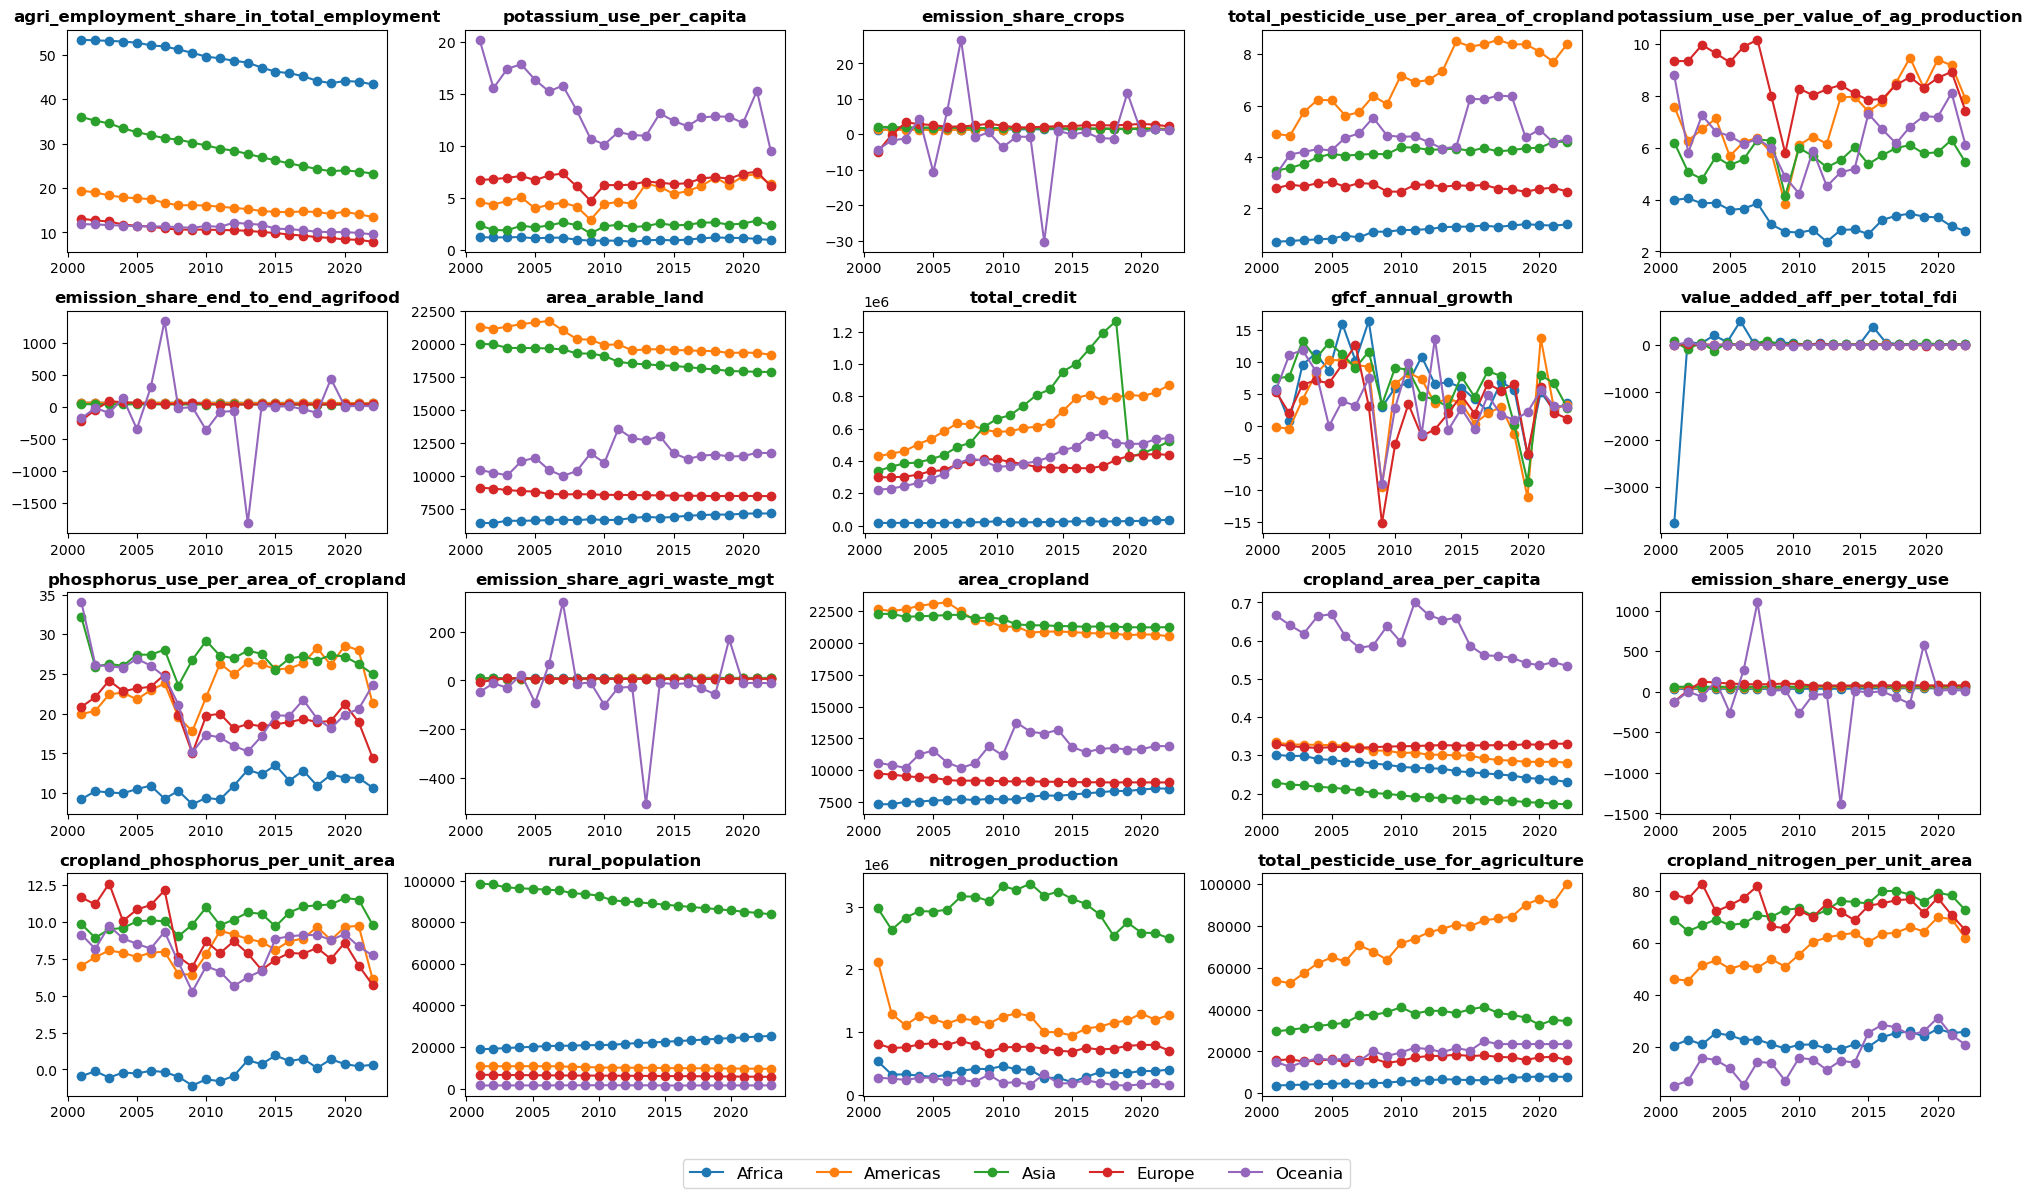

In [544]:
# Set up figure and axes grid
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20,12))

# Flatten 2D array of axes for easier indexing
axes = axes.flatten()

# Keep track of region labels for one legend
region_labels = set()

# Plotting time series for first 20 variables
for idx, col in enumerate(cols_area_dependent[0:20]):
    ax = axes[idx]

    # Aggregate and pivot the data
    data_agg = df_2.groupby(['year', 'region'])[col].mean().reset_index()

    data_pivot = data_agg.pivot(
        index = 'year',
        columns = 'region',
        values = col
    )

    # Plot each region's trend
    for region in data_pivot.columns:
        ax.plot(data_pivot.index, data_pivot[region], label=region, marker='o')
        region_labels.add(region)

    ax.set_title(col, fontweight='bold')

# Add a single legend below all sub-plots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(region_labels), fontsize='large')

plt.tight_layout(rect=[0,0.05,1,1])
plt.show()

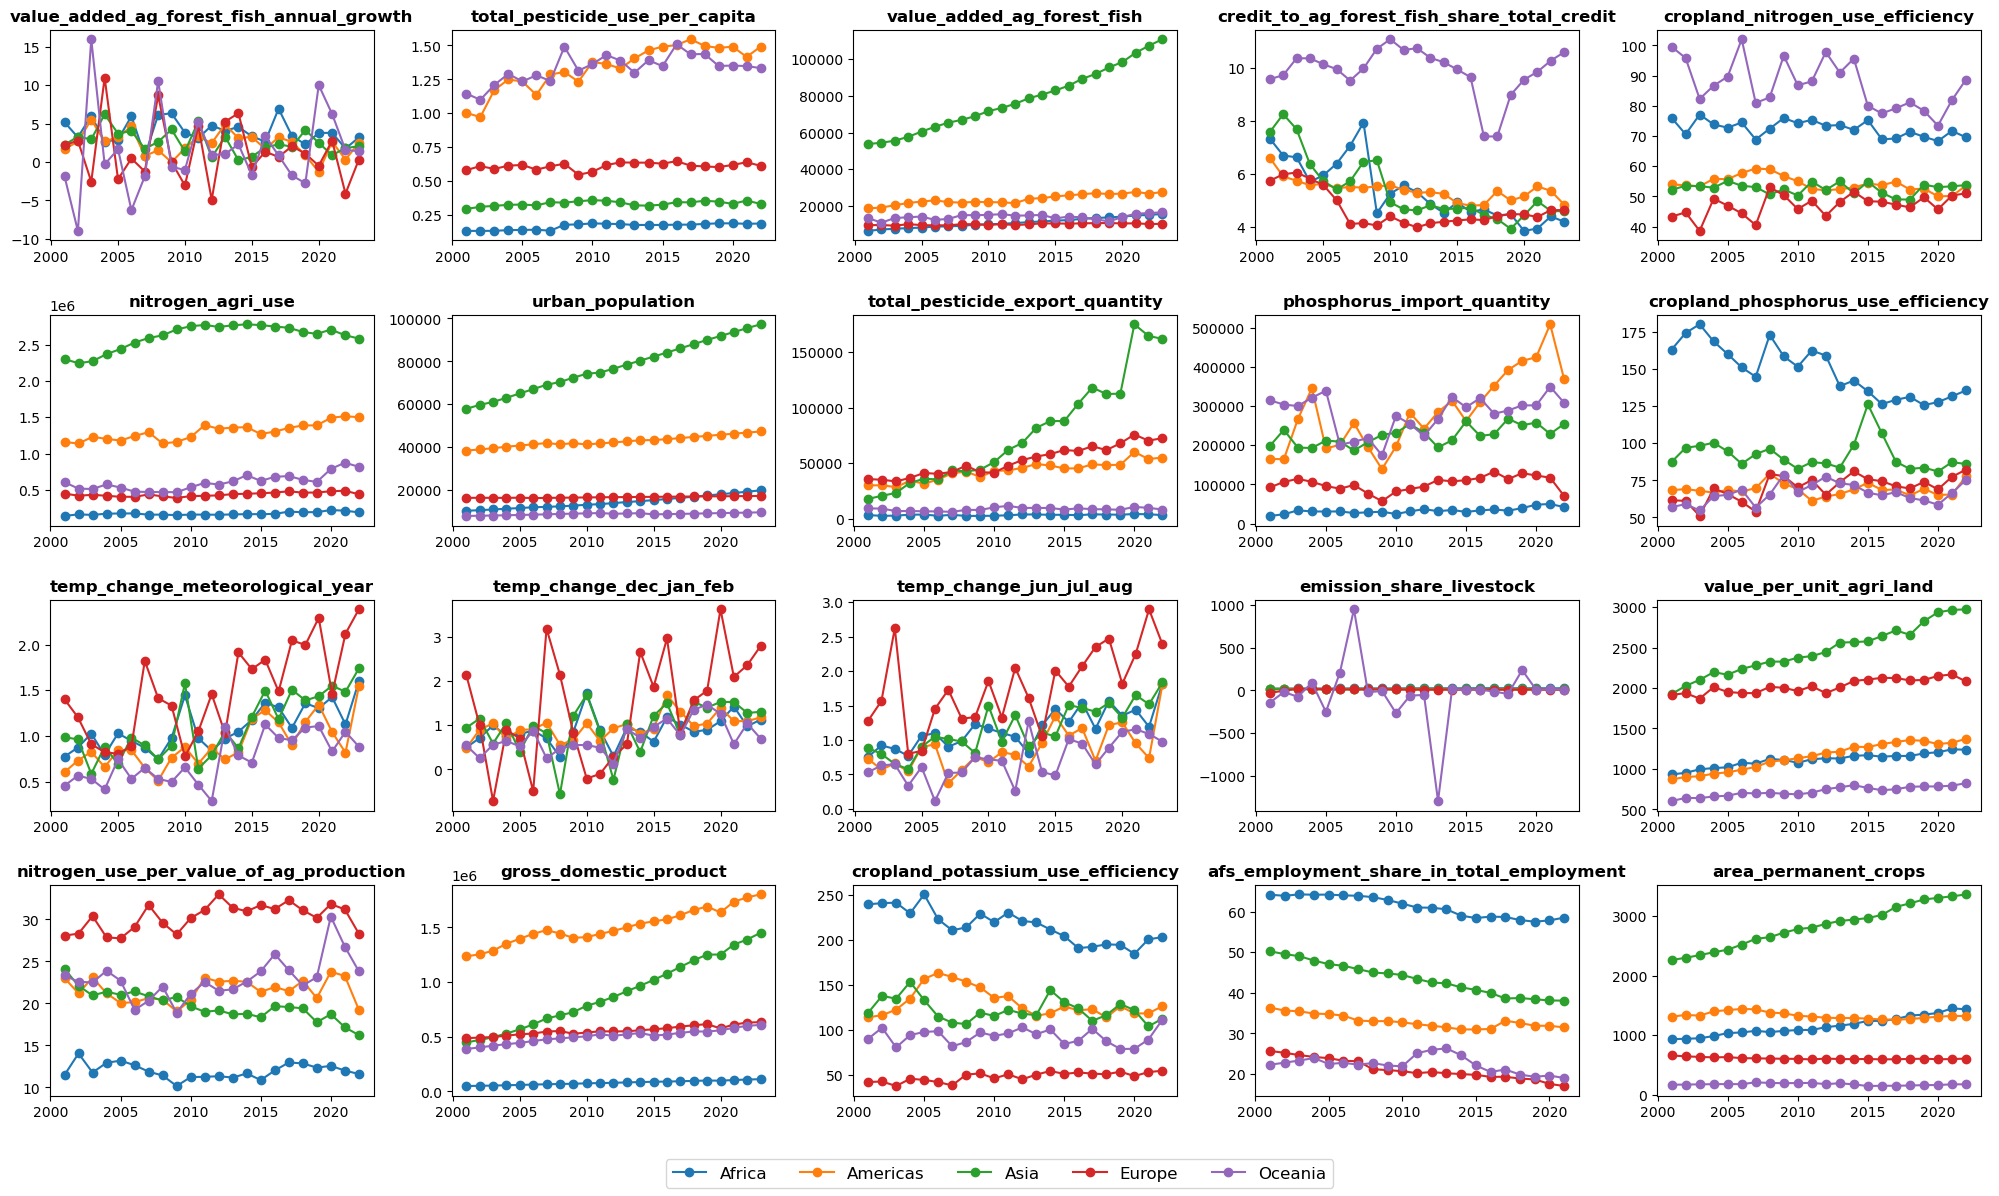

In [545]:
# Set up figure and axes grid
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20,12))

# Flatten the 2D array of axes for easier indexing
axes = axes.flatten()

# Keep track of the region labels for the legend
region_labels = set()

# Plotting time series for next twenty (20-40) variables
for idx, col in enumerate(cols_area_dependent[20:40]):
    ax = axes[idx]

    # Aggregate and pivot the data
    data_agg = df_2.groupby(['year', 'region'])[col].mean().reset_index()

    data_pivot = data_agg.pivot(index='year', columns='region', values=col)

    # Plot each region's trend
    for region in data_pivot.columns:
        ax.plot(data_pivot.index, data_pivot[region], label=region, marker='o')
        region_labels.add(region)

    ax.set_title(col, fontweight='bold')

# Add a single legend below all sub-plots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(region_labels), fontsize='large')

plt.tight_layout(rect=[0,0.05,1,1])
plt.show()

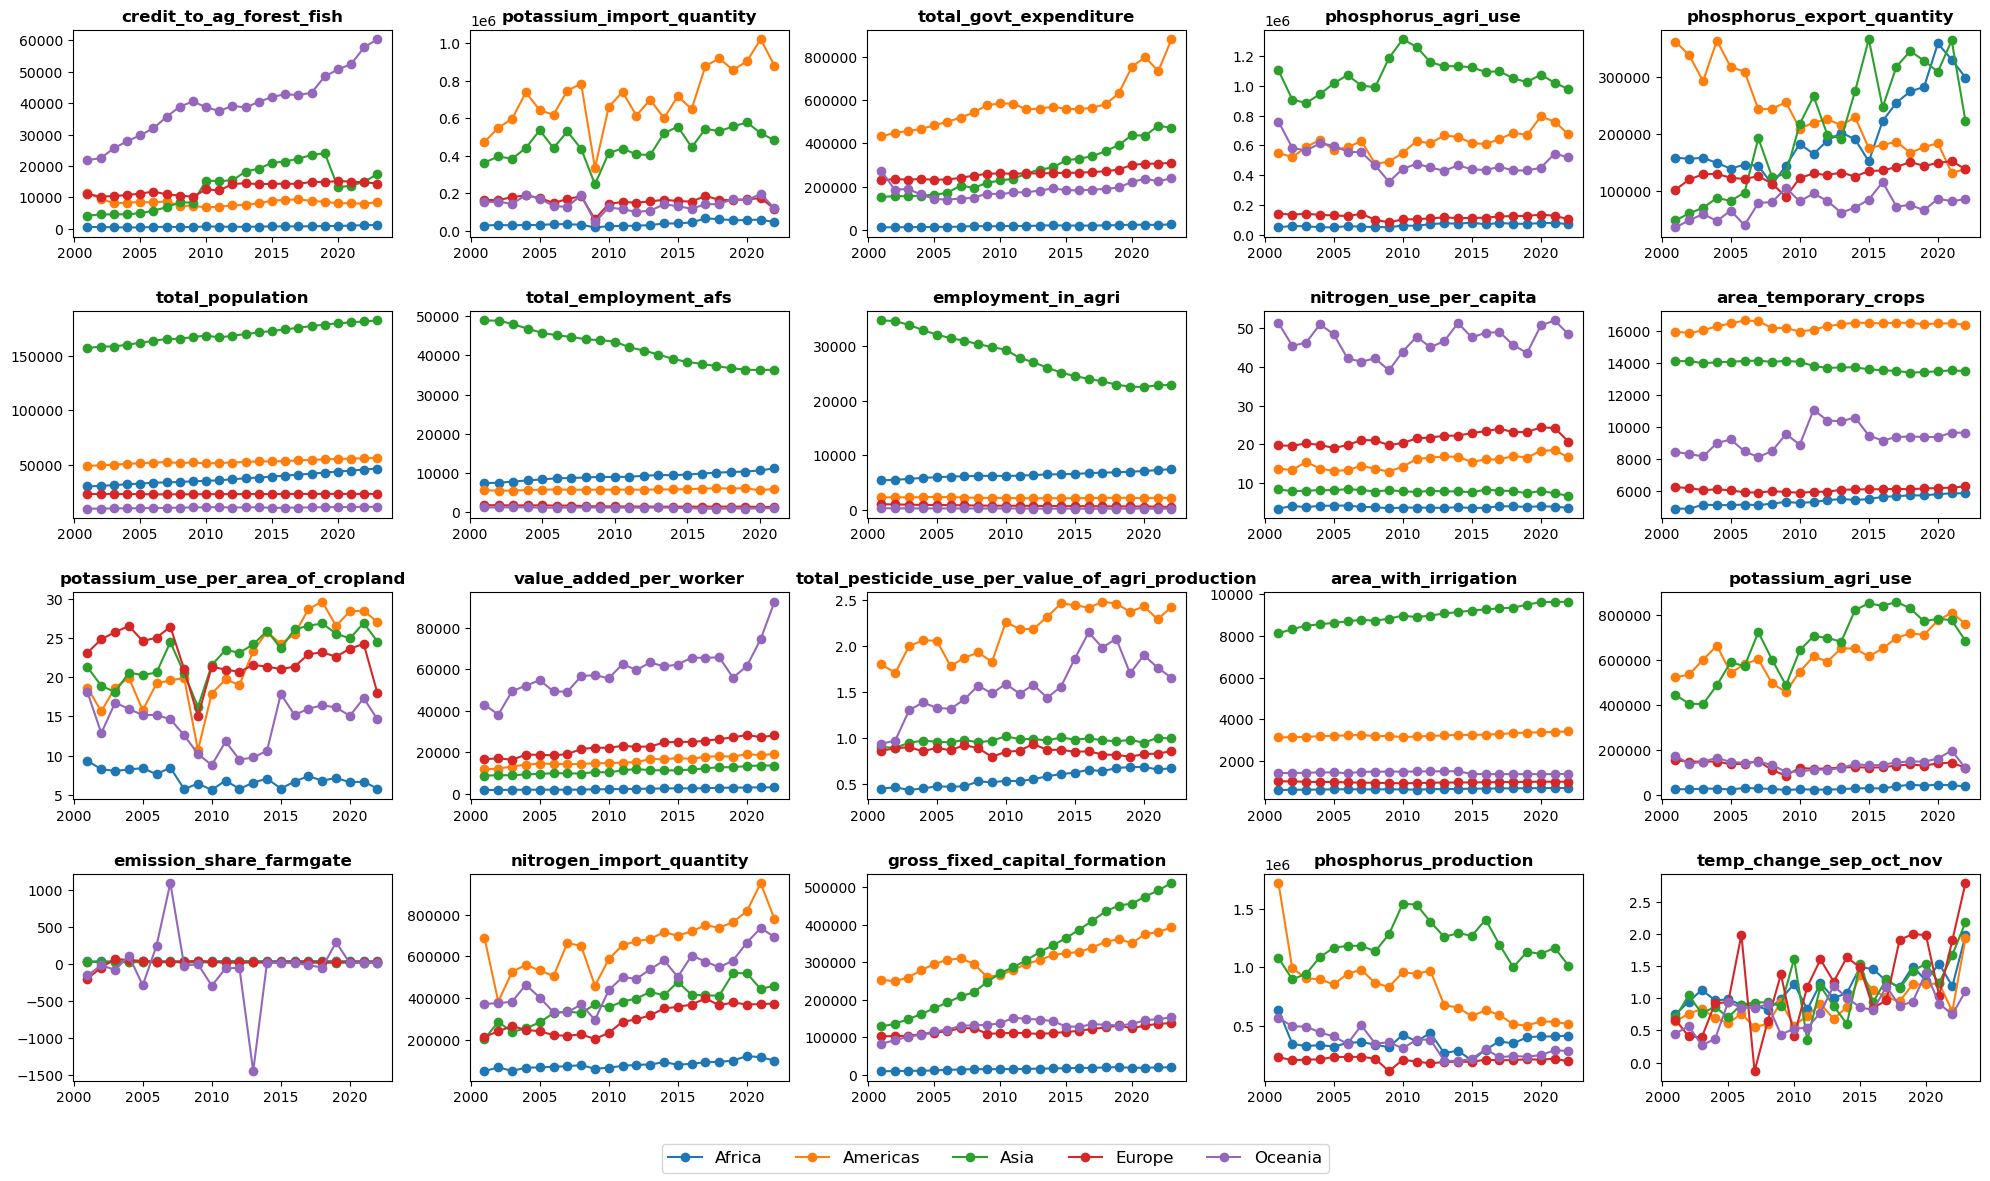

In [546]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20,12))

axes = axes.flatten()

region_labels = set()

for idx, col in enumerate(cols_area_dependent[40:60]):
    ax = axes[idx]

    data_agg = df_2.groupby(['year', 'region'])[col].mean().reset_index()

    data_pivot = data_agg.pivot(index='year', columns='region', values=col)

    for region in data_pivot.columns:
        ax.plot(data_pivot.index, data_pivot[region], label=region, marker='o')
        region_labels.add(region)

    ax.set_title(col, fontweight='bold')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(region_labels), fontsize='large')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

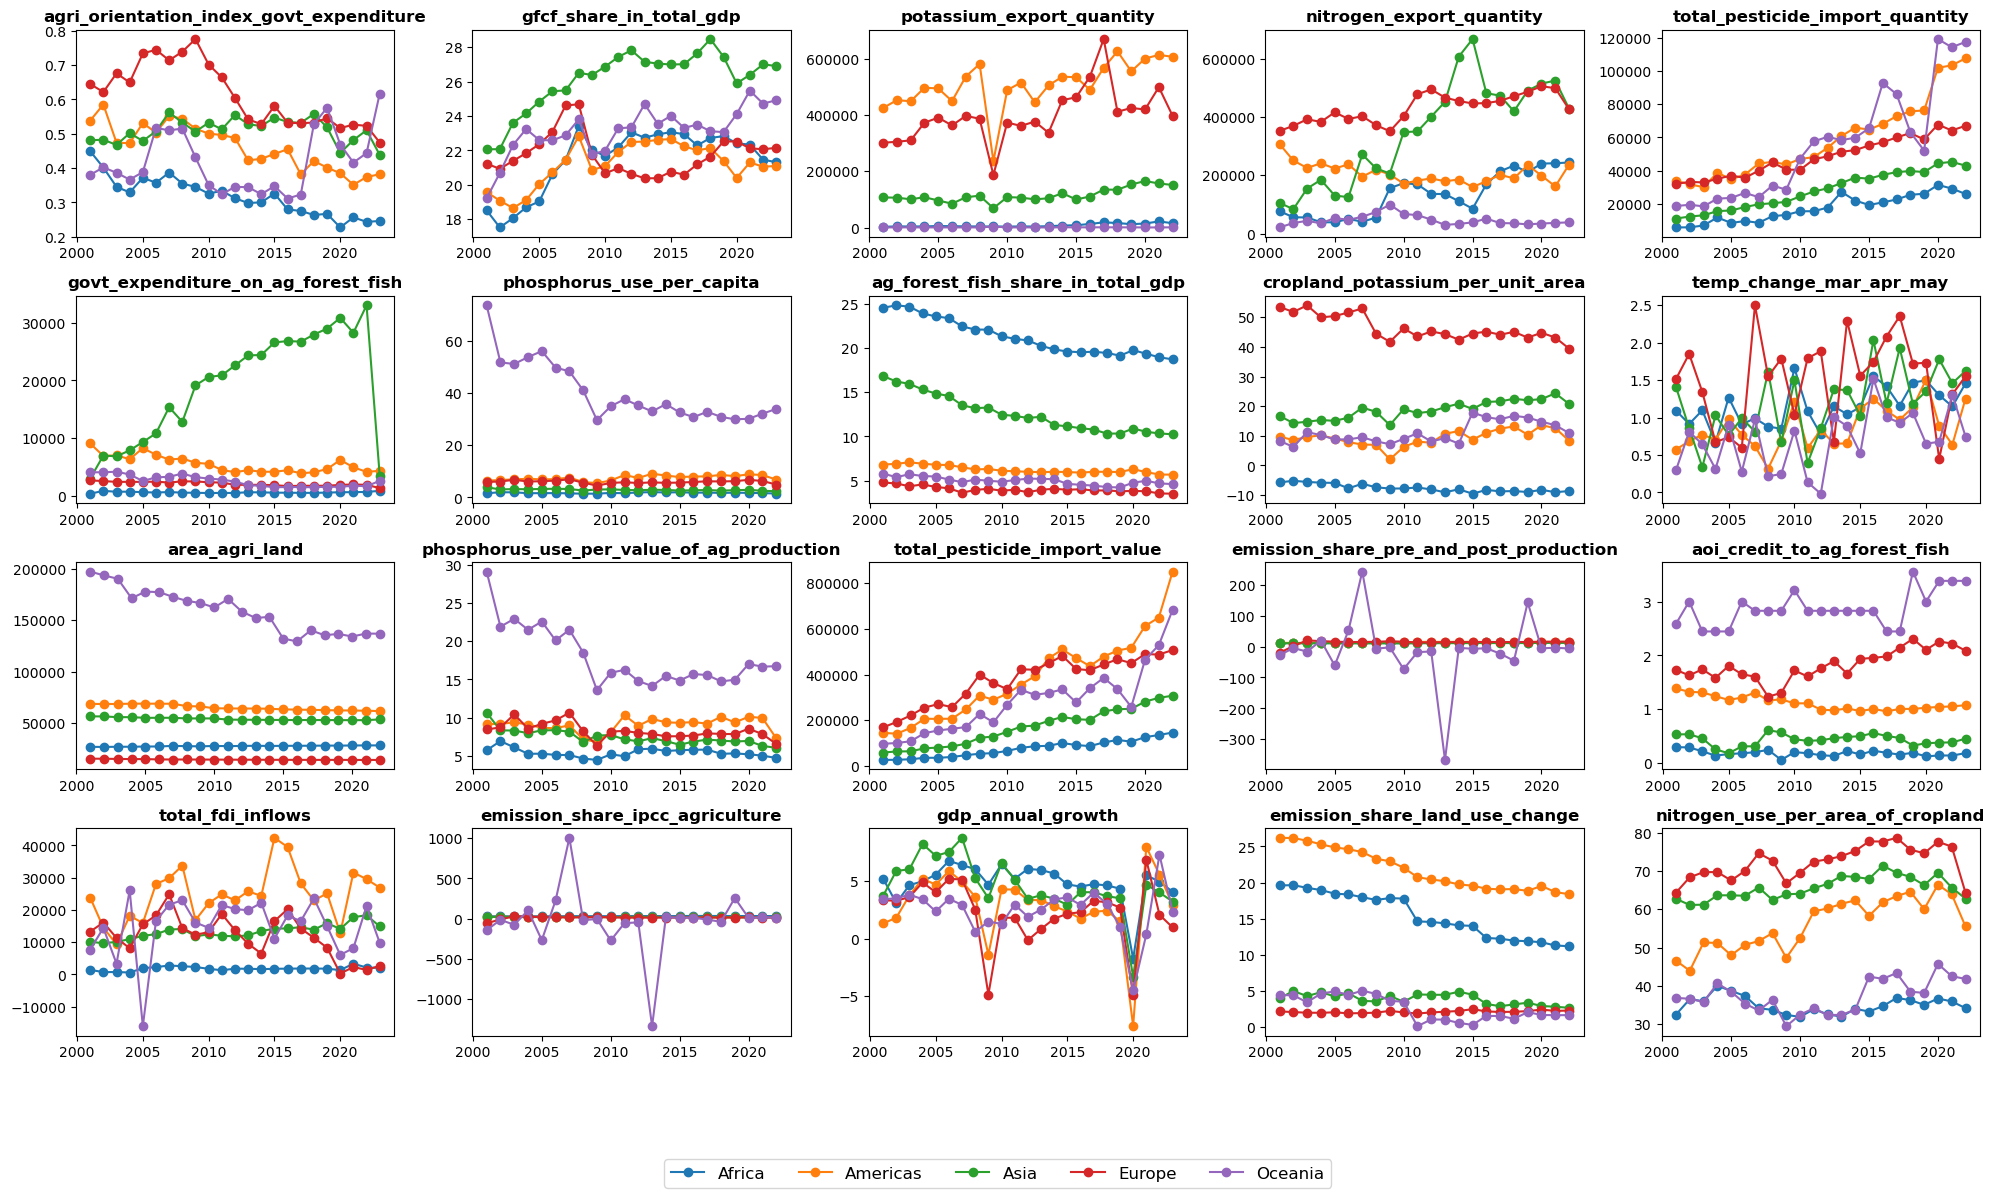

In [547]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20,12))

axes = axes.flatten()

region_labels = set()

for idx, col in enumerate(cols_area_dependent[60:80]):
    ax = axes[idx]

    # Aggregate and pivot the data
    data_agg = df_2.groupby(['year', 'region'])[col].mean().reset_index()

    data_pivot = data_agg.pivot(index='year', columns='region', values=col)

    # Plot each region's trend
    for region in data_pivot.columns:
        ax.plot(data_pivot.index, data_pivot[region], label=region, marker='o')
        region_labels.add(region)

    ax.set_title(col, fontweight='bold')

# Hide unused plots
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

# Add a single legend below all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(region_labels), fontsize='large')

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

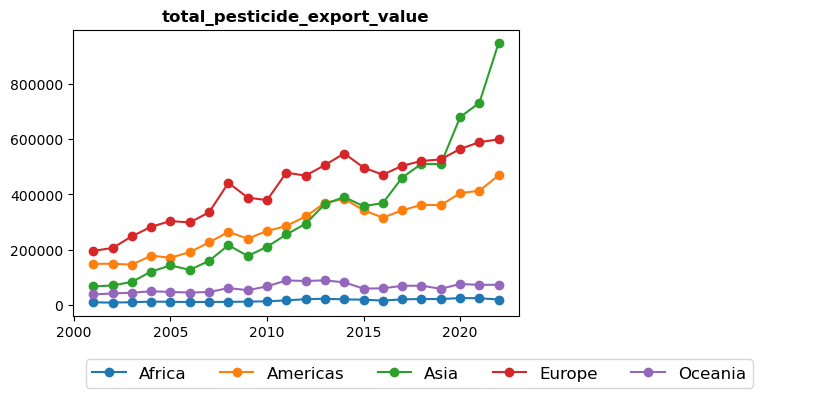

In [550]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

axes = axes.flatten()

region_labels = set()

for idx, col in enumerate(cols_area_dependent[80:]):
    ax = axes[idx]

    # Aggregate and pivot the data
    data_agg = df_2.groupby(['year', 'region'])[col].mean().reset_index()

    data_pivot = data_agg.pivot(index='year', columns='region', values=col)

    # Plot each region's trend
    for region in data_pivot.columns:
        ax.plot(data_pivot.index, data_pivot[region], label=region, marker='o')
        region_labels.add(region)

    ax.set_title(col, fontweight='bold')

# Hide unused plots
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

# Add a single legend below all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(region_labels), fontsize='large')

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

From the plots, area- and population-related variables exhibit approximately 
constant—at most linear—trends over time. By contrast, variables related to 
fertilizers, trade (imports/exports), and finance are markedly more volatile 
and do not follow a stable linear pattern.

In [ ]:
# Creating training subset (year <= 2021)
#train_temp_df_2 = df_2.loc[df_2['year'] <= 2021]
#train_temp_df_2['year'].dtype

dtype('int64')

In [ ]:
#train_temp_df_2.shape

(125110, 106)

In [291]:
# List of columns that are both area- and item-dependent, 
# which we want to remove before further processing.
cols_area_and_item_dependent = [
    'export_quantity', 'export_value', 'import_quantity',
    'import_value', 'area_harvested', 'production', 'yield',
    'gross_production_value', 'gross_production_index', 'producer_price_index',
    'item', 'item_code'
]

# create a new DataFrame that only contains area-dependent variables
df_2_area = df_2.drop(cols_area_and_item_dependent, axis = 1)
df_2_area.shape

(137356, 94)

The current dataframe contains duplicate entries for specific (country-year) pairs
corresponding to different items. Since, we are now imputing missing values in 
variables that are item-independent, we would just drop the duplicate (country-year) 
pairs.

In [292]:
# Remove duplicate rows where both 'area' and 'year' values are the same.
df_2_area = df_2_area.drop_duplicates(subset=['area', 'year'])
df_2_area.shape

(3267, 94)

Missing values in temperature change–related columns for a given country can be 
imputed using data from other countries within the same geographical region or 
sub-region. This approach is reasonable because temperature change tends to 
follow broadly similar trends within a region. For instance, countries across 
Eastern Europe are expected to experience comparable shifts in temperature over 
time.

In [293]:
df_2_area['temp_change_dec_jan_feb'].isna().mean()*100

np.float64(2.2344658708295073)

In [294]:
df_2_area['temp_change_jun_jul_aug'].isna().mean()*100

np.float64(2.326293235384145)

In [295]:
df_2_area.loc[df_2_area['temp_change_jun_jul_aug'].isna()]['area'].unique()

array(['Antigua and Barbuda', 'Barbados', 'Burundi', 'Cabo Verde',
       'Costa Rica', 'Malawi', 'Rwanda', 'Singapore', 'Yemen'],
      dtype=object)

In [296]:
df_2_area.loc[df_2_area['temp_change_meteorological_year'].isna()]['area'].unique()

array(['Antigua and Barbuda', 'Barbados', 'Burundi', 'Cabo Verde',
       'Costa Rica', 'Rwanda', 'Singapore', 'Yemen'], dtype=object)

In [297]:
df_2_area.loc[df_2_area['temp_change_mar_apr_may'].isna()]['area'].unique()

array(['Antigua and Barbuda', 'Barbados', 'Burundi', 'Cabo Verde',
       'Costa Rica', 'Rwanda', 'Yemen'], dtype=object)

There are five columns associated with temperature change, each with a relatively 
low level of missingness (about 2–3%). These gaps can be reliably imputed by 
using the mean temperature change calculated across all countries within the same 
sub-region. Since climatic shifts tend to be regionally consistent, sub-regional 
averages provide a robust and straightforward basis for filling these missing values.

In [298]:
# Define the list of temperature change columns
cols_seasonal = [
    'temp_change_meteorological_year', 'temp_change_dec_jan_feb',
    'temp_change_jun_jul_aug', 'temp_change_sep_oct_nov', 'temp_change_mar_apr_may'  
    ]

# Create a list of all other area-dependent columns that are NOT part of the
# seasonal temperature change set.
cols_non_seasonal = list(set(cols_area_dependent)- set(cols_seasonal))

In [299]:
for col in cols_seasonal:
    # Group the data by 'area', 'year', and 'sub_region' 
    # and calculate the mean of the current seasonal column.
    df_country_year = df_2_area.groupby(['area', 'year', 'sub_region'], as_index=False)[col].mean()

    # Fill missing values in the seasonal column by using the 
    # mean value of the corresponding 'year' and 'sub_region'.
    df_country_year[col] = df_country_year[col].fillna(
        df_country_year.groupby(['year', 'sub_region'])[col].transform('mean')
    )

    # Drop the original seasonal column from df_2_area and then merge back
    # the imputed values from df_country_year.
    df_2_area = df_2_area.drop(col, axis=1).merge(
        df_country_year[['area', 'year', 'sub_region', col]],
        on = ['area', 'year', 'sub_region'],
        how = 'left'
    )

In [300]:
df_2_area.loc[df_2_area['temp_change_meteorological_year'].isna()]['area'].unique()

array([], dtype=object)

In [301]:
df_2_area.loc[df_2_area['temp_change_jun_jul_aug'].isna()]['area'].unique()

array([], dtype=object)

At this stage, we can address the simpler imputation task: filling short gaps of 
one or two consecutive missing values at the beginning, middle, or end of a time 
series. For these cases, straightforward techniques such as linear interpolation, 
last observation carried forward (LOCF), or next observation carried backward (NOCB) 
are appropriate. Even if the overall series is not strictly linear, assuming a 
linear trend across such small gaps is unlikely to introduce meaningful bias 
into the modeling process.

In [302]:
# Output reflects the different kinds of missing data gaps in the dataset.
df_2_area[
    ['area', 'year', 'govt_expenditure_on_ag_forest_fish',
     'credit_to_ag_forest_fish', 'nitrogen_production']
][0:30]

,area,year,govt_expenditure_on_ag_forest_fish,credit_to_ag_forest_fish,nitrogen_production
0,Afghanistan,2001,NaN,NaN,18400.0
1,Afghanistan,2002,NaN,NaN,23414.0
2,Afghanistan,2003,NaN,NaN,16206.0
3,Afghanistan,2004,NaN,NaN,19458.0
4,Afghanistan,2005,NaN,NaN,15631.0
5,Afghanistan,2006,153.30,NaN,17636.0
6,Afghanistan,2007,332.82,NaN,16973.0
7,Afghanistan,2008,335.91,1.259477,15324.0
8,Afghanistan,2009,465.10,NaN,13606.0
9,Afghanistan,2010,595.72,11.894427,12022.0


In [303]:
# Function to fill only the first/last single-point gaps
def fill_boundary_single_gaps(s):
    # Make a copy to avoid modifying the original series
    filled_s = s.copy()

    # Check for NaN at the beginning of the series
    if pd.isnull(filled_s.iloc[0]) and pd.notnull(filled_s.iloc[1]):
        filled_s.iloc[0] = filled_s.iloc[1]

    # Check for NaN at the end of the series
    if pd.isnull(filled_s.iloc[-1]) and pd.notnull(filled_s.iloc[-2]):
        filled_s.iloc[-1] = filled_s.iloc[-2]

    return filled_s

# Apply the custom function using groupby().transform()
for col in cols_non_seasonal:
    # Fill gaps of 1 at beginning and end of series
    df_2_area[col] = df_2_area.groupby('area')[col].transform(fill_boundary_single_gaps)

    # Fill remaining internal gaps of 1 or 2 using linear interpolation
    df_2_area[col] = df_2_area.groupby('area')[col].transform(
    lambda s: s.interpolate(method='linear', limit=2, limit_area='inside')
    )

In [304]:
# Output confirms that the short-gaps have been filled as expected
df_2_area[
    ['area', 'year', 'govt_expenditure_on_ag_forest_fish',
     'credit_to_ag_forest_fish', 'nitrogen_production']
    ][0:30]

,area,year,govt_expenditure_on_ag_forest_fish,credit_to_ag_forest_fish,nitrogen_production
0,Afghanistan,2001,NaN,NaN,18400.0
1,Afghanistan,2002,NaN,NaN,23414.0
2,Afghanistan,2003,NaN,NaN,16206.0
3,Afghanistan,2004,NaN,NaN,19458.0
4,Afghanistan,2005,NaN,NaN,15631.0
5,Afghanistan,2006,153.30,NaN,17636.0
6,Afghanistan,2007,332.82,NaN,16973.0
7,Afghanistan,2008,335.91,1.259477,15324.0
8,Afghanistan,2009,465.10,6.576952,13606.0
9,Afghanistan,2010,595.72,11.894427,12022.0


In [308]:
df_2_area[
    ['area', 'year' ,'govt_expenditure_on_ag_forest_fish', 'credit_to_ag_forest_fish', 
    'nitrogen_production', 'phosphorus_production', 'total_credit', 'area_agri_land']
    ][382:420]

,area,year,govt_expenditure_on_ag_forest_fish,credit_to_ag_forest_fish,nitrogen_production,phosphorus_production,total_credit,area_agri_land
382,Bosnia and Herzegovina,2001,NaN,NaN,NaN,NaN,1344.0,2126.0
383,Bosnia and Herzegovina,2002,NaN,NaN,NaN,NaN,1633.0,2123.0
384,Bosnia and Herzegovina,2003,NaN,NaN,NaN,NaN,1934.0,2169.0
385,Bosnia and Herzegovina,2004,NaN,NaN,NaN,NaN,2188.0,2169.4
386,Bosnia and Herzegovina,2005,NaN,NaN,NaN,NaN,2628.0,2157.0
387,Bosnia and Herzegovina,2006,NaN,NaN,NaN,NaN,2802.0,2159.0
388,Bosnia and Herzegovina,2007,NaN,85.955912,NaN,NaN,3243.0,2149.0
389,Bosnia and Herzegovina,2008,NaN,96.736206,NaN,NaN,3390.0,2130.0
390,Bosnia and Herzegovina,2009,NaN,114.938099,44310.00,NaN,3442.0,2128.0
391,Bosnia and Herzegovina,2010,NaN,108.735478,31717.00,NaN,3477.0,2144.0


During data exploration, we found that the columns nitrogen_production and 
phosphorus_production contain many zero values for certain countries. This is 
reasonable, as smaller economies may not produce these nutrients domestically 
and instead rely on imports. To address this, we will impute some of the missing 
values in these two columns following a set of defined rules outlined below.

In [309]:
# Three conditional rules for filling NaNs in two columns- 'nitrogen_production' 
# and 'phosphorus production'

"""
rule 1: If the first non-missing value in the series is 0, then fill all 
        preceding NaNs with 0.

rule 2: If the last non-missing value in the series is 0, then fill all 
        following NaNs with 0.

rule 3: If more than 50% of the non-missing values in the series are 0, then fill 
        all NaNs with 0.
"""

def fill_missing_custom(s: pd.Series) -> pd.Series:
    # rule 1: Leading NaNs followed by 0
    fvi = s.first_valid_index()
    if fvi is not None and s.loc[fvi] == 0:
        s.loc[:fvi] = s.loc[:fvi].fillna(0)

    # rule 2: Trailing NaNs preceded by 0
    lvi = s.last_valid_index()
    if lvi is not None and s.loc[lvi] == 0:
        s.loc[lvi:] = s.loc[lvi:].fillna(0)

    # rule 3: Majority of non-missing are 0
    non_missing = s.dropna()
    if len(non_missing) > 0 and (non_missing == 0).mean() > 0.5:
        s = s.fillna(0)

    return s

# Apply to each group and for the two target columns
target_cols = ['nitrogen_production', 'phosphorus_production']

for col in target_cols:
    df_2_area[col] = (
        df_2_area.groupby('area')[col]
        .apply(lambda group: fill_missing_custom(group.copy()))
        .reset_index(level=0, drop=True)
    )


In [310]:
# Output confirms that the missing gaps in columns- 'nitrogen_production' and 
# 'phosphorus_production' are imputed (not all NaNs) as expected as per the rules above. 
df_2_area[
    ['area', 'year' ,'govt_expenditure_on_ag_forest_fish', 'credit_to_ag_forest_fish', 
    'nitrogen_production', 'phosphorus_production', 'total_credit', 'area_agri_land']
    ][382:420]

,area,year,govt_expenditure_on_ag_forest_fish,credit_to_ag_forest_fish,nitrogen_production,phosphorus_production,total_credit,area_agri_land
382,Bosnia and Herzegovina,2001,NaN,NaN,NaN,0.00,1344.0,2126.0
383,Bosnia and Herzegovina,2002,NaN,NaN,NaN,0.00,1633.0,2123.0
384,Bosnia and Herzegovina,2003,NaN,NaN,NaN,0.00,1934.0,2169.0
385,Bosnia and Herzegovina,2004,NaN,NaN,NaN,0.00,2188.0,2169.4
386,Bosnia and Herzegovina,2005,NaN,NaN,NaN,0.00,2628.0,2157.0
387,Bosnia and Herzegovina,2006,NaN,NaN,NaN,0.00,2802.0,2159.0
388,Bosnia and Herzegovina,2007,NaN,85.955912,NaN,0.00,3243.0,2149.0
389,Bosnia and Herzegovina,2008,NaN,96.736206,NaN,0.00,3390.0,2130.0
390,Bosnia and Herzegovina,2009,NaN,114.938099,44310.00,0.00,3442.0,2128.0
391,Bosnia and Herzegovina,2010,NaN,108.735478,31717.00,0.00,3477.0,2144.0


At this point, the remaining challenge is to address the large gaps of missing values in the dataset, which require more advanced imputation strategies. Since the data are structured as a multi-panel time series, one possible approach would be to apply time series models to impute missing values within each individual series. However, there are several limitations to this option:

1. **Short length of series:**  Each time series contains only 21 time points, which is quite limited for reliable time series modeling.

2. **High degree of missingness:** Some series are missing values across many time points, and in certain cases, an entire series for a variable is absent. This leaves very few data points to infer from.

3. **Lack of autocorrelation:** Even for series with a reasonable number of observations, time series modeling is not always viable. Autocorrelation must be significant for past values to help predict missing ones. If no autocorrelation is present, imputation essentially reduces to filling values with the mean, which is not informative.

Given these challenges, supervised machine learning models that leverage both cross-sectional information (data across different countries or units) and within-panel information (data within the same series) offer a more promising direction for imputing missing values. This dual perspective allows the model to borrow strength from related variables and countries when individual time series are too sparse.

As shown in the autocorrelation plots below, the absence of meaningful autocorrelation in a sample of series further underscores the limitations of time series–only methods and highlights the need for cross-sectional ML-based approaches.

In [311]:
# Example 1:
s1 = df_2_area.loc[df_2_area['area']=='Bosnia and Herzegovina'][['year', 'credit_to_ag_forest_fish']].set_index('year')
s1

,credit_to_ag_forest_fish
year,
2001,NaN
2002,NaN
2003,NaN
2004,NaN
2005,NaN
2006,NaN
2007,85.955912
2008,96.736206
2009,114.938099


In [312]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

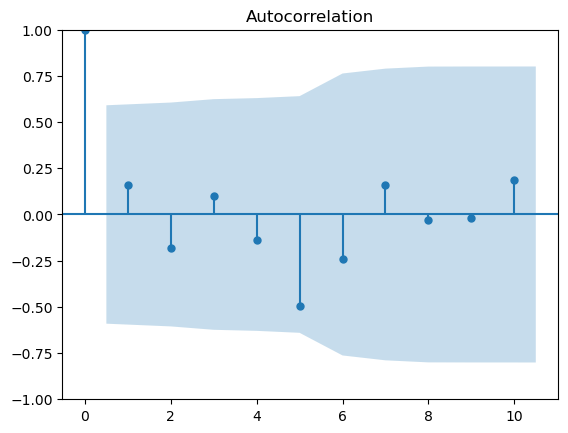

In [313]:
clean = s1.dropna()

fig, ax = plt.subplots()
plot_acf(clean, lags = 10, ax=ax)
plt.show()

In [314]:
# Example 2:
s2 = df_2_area.loc[df_2_area['area']=='Yemen'][['year', 'total_fdi_inflows']].set_index('year')
s2

,total_fdi_inflows
year,
2001,469.641464
2002,333.594662
2003,-248.487070
2004,363.652403
2005,-659.699092
2006,2138.337900
2007,1611.337735
2008,2395.359058
2009,215.748224


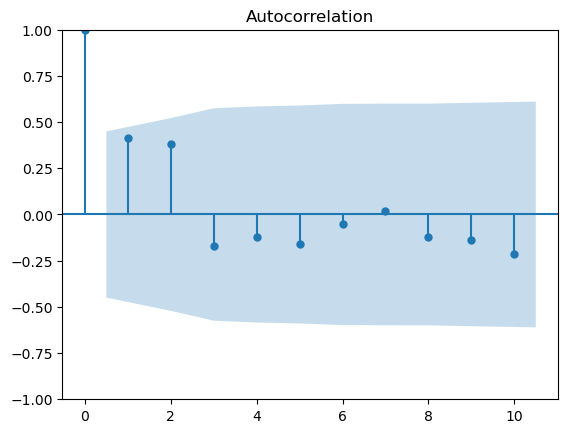

In [315]:
clean = s2.dropna()

fig, ax = plt.subplots()
plot_acf(clean, lags = 10, ax=ax)
plt.show()

In [316]:
# Example 3
s3 = df_2_area.loc[df_2_area['area']=='Afghanistan'][['year', 'credit_to_ag_forest_fish']].set_index('year')
s3

,credit_to_ag_forest_fish
year,
2001,NaN
2002,NaN
2003,NaN
2004,NaN
2005,NaN
2006,NaN
2007,NaN
2008,1.259477
2009,6.576952


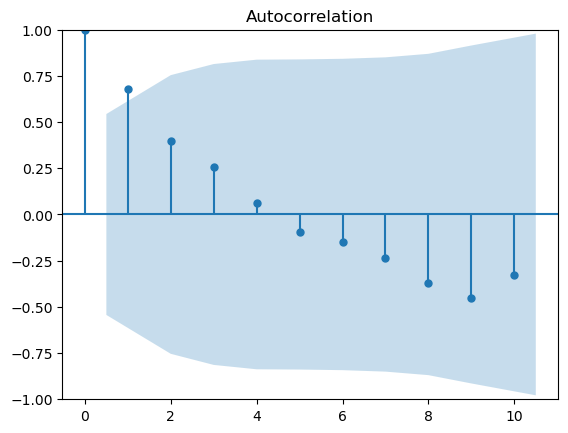

In [317]:
clean = s3.dropna()

fig, ax = plt.subplots()
plot_acf(clean, lags = 10, ax=ax)
plt.show()

In [318]:
# Example 4:
s4 = df_2_area.loc[df_2_area['area']=='Ghana'][['year', 'credit_to_ag_forest_fish']].set_index('year')
s4

,credit_to_ag_forest_fish
year,
2001,NaN
2002,NaN
2003,NaN
2004,136.203230
2005,140.749407
2006,134.055657
2007,170.874474
2008,199.765499
2009,222.154053


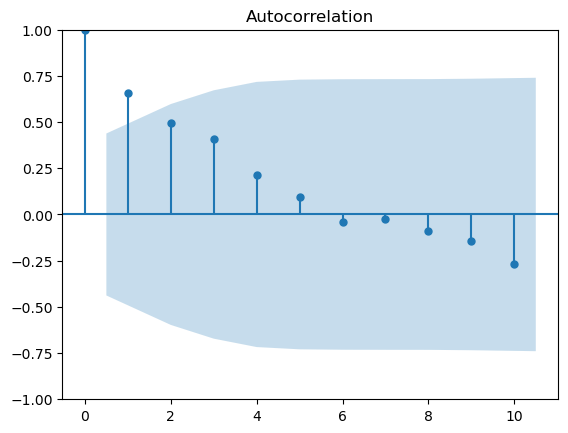

In [319]:
clean = s4.dropna()

fig, ax = plt.subplots()
plot_acf(clean, lags = 10, ax=ax)
plt.show()

In short, the time series has weak autocorrelation overall, with only a small 
short-term dependency at lag 1 (and maybe lag 2). After that, it behaves more 
like noise. This makes classical time series models (like ARIMA) less effective 
for imputation, since they rely on strong, sustained autocorrelation.

## Data Imputation (large gaps) using LightGBM

#### Why LightGBM regressors are better suited in our scenario?

**Cross-sectional strength:**
LightGBM can learn from other variables (fertilizer use, production, trade, temperature, etc.) across the dataset. So even if one country’s time series is incomplete, it can “borrow” information from similar countries, years, or correlated features.

**Handles non-linearities:**
Many trade/economic variables don’t follow linear patterns. LightGBM captures complex, non-linear relationships without you having to hand-specify functional forms.

**Robust to mixed data:**
You’ve got categorical (countries, regions), continuous (production, prices), and semi-seasonal variables. LightGBM natively handles these heterogeneous inputs well.

**Good with missingness:**
Tree-based models (like LightGBM) have built-in mechanisms to route missing values, so you don’t need perfect pre-cleaning. That makes it naturally more forgiving in imputation tasks.

**Scalable across panels:**
Since your dataset is multi-country and multi-variable, LightGBM can be fit across all panels at once, finding shared patterns rather than treating each series as isolated.

In [ ]:
# Loading packages
from lightgbm import LGBMRegressor

In [ ]:
"""
First, we create a list of columns that are having missing values and so 
needs to be imputed by the LightGBM model.
"""

# work on a copy of the original dataframe
df = df_2_area.copy()

# categorical columns
cat_cols = ['area', 'year', 'region', 'sub_region']

# columns to exclude (irrelevant)
exclude_cols = ['area_code', 'area_code_m49', 'year_code']

# Make categoricals truly categorical so LightGBM can handle them natively
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype('category')

# Numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.to_list()

# Counting number of NaNs per numeric column
miss_counts = df[num_cols].isna().sum()

# Columns that actually need imputation, sorted by missingness (ascending)
to_impute = (
    miss_counts.loc[miss_counts > 0]
    .sort_values(ascending=True)
    .index.to_list()
)

print(f"Columns to impute (low --> high missingness): {to_impute[0:5]}{'...' if len(to_impute)>10 else ''}")

print(f"Number of columns to impute: {len(to_impute)}")

Columns to impute (low --> high missingness): ['area_agri_land', 'value_per_unit_agri_land', 'total_pesticide_import_quantity', 'area_permanent_crops', 'cropland_potassium_use_efficiency']...
Number of columns to impute: 55


In [ ]:
"""
Missing values in item-independent columns were imputed using a LightGBM regressor 
model. The model was trained exclusively on complete data from 2001-2021 and then 
applied to impute missing entries across the full dataset spanning 2001-2023. 

Importantly, the model was not trained on any data from the period used for 
forecasting, ensuring no information leakage into the evaluation phase. 
"""

for col in to_impute:
    # Masks
    train_mask = (df['year'].isin(list(range(2001, 2021)))) & (df[col].notna())
    pred_mask = df[col].isna()

    # Predictors
    X_cols = [c for c in df.columns if c != col and c not in exclude_cols]

    # Training data
    X_train = df.loc[train_mask, X_cols]
    y_train = df.loc[train_mask, col]

    # Choose objective
    y_min = y_train.min()

    if y_min >= 0:
        obj = "tweedie"
    else:
        obj = "regression"


    # LightGBM model
    model = LGBMRegressor(
        objective=obj,
        n_estimators=800,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Predict all missing rows (2001-2023)
    X_pred = df.loc[pred_mask, X_cols]
    y_pred = model.predict(X_pred)


    df.loc[pred_mask, col] = y_pred

print("Done imputing.")


Done imputing.


In [394]:
df_2_area[
    ['area', 'year' ,'govt_expenditure_on_ag_forest_fish', 'credit_to_ag_forest_fish', 
    'nitrogen_production', 'phosphorus_production', 'total_credit', 'afs_employment_share_in_total_employment']
    ][60:90]

,area,year,govt_expenditure_on_ag_forest_fish,credit_to_ag_forest_fish,nitrogen_production,phosphorus_production,total_credit,afs_employment_share_in_total_employment
60,Antigua and Barbuda,2008,NaN,3.033720,0.0,0.0,1298.0,NaN
61,Antigua and Barbuda,2009,NaN,2.830350,0.0,0.0,1268.0,NaN
62,Antigua and Barbuda,2010,NaN,2.186226,0.0,0.0,1174.0,NaN
63,Antigua and Barbuda,2011,NaN,2.286473,0.0,0.0,1140.0,NaN
64,Antigua and Barbuda,2012,NaN,2.097191,0.0,0.0,1082.0,NaN
65,Antigua and Barbuda,2013,NaN,1.928644,0.0,0.0,1066.0,NaN
66,Antigua and Barbuda,2014,3.430000,0.541414,0.0,0.0,999.0,NaN
67,Antigua and Barbuda,2015,2.960000,0.462593,0.0,0.0,910.0,NaN
68,Antigua and Barbuda,2016,3.368333,0.428999,0.0,0.0,883.0,NaN
69,Antigua and Barbuda,2017,3.776667,0.191562,0.0,0.0,888.0,NaN


In [363]:
df_2_area['govt_expenditure_on_ag_forest_fish'].describe()

count      2361.000000
mean       4173.193393
std       23411.032370
min           0.430000
25%          87.440000
50%         345.790000
75%        1559.870000
max      355767.150000
Name: govt_expenditure_on_ag_forest_fish, dtype: float64

In [364]:
df['govt_expenditure_on_ag_forest_fish'].describe()

count      3267.000000
mean       3144.462160
std       20000.285879
min           0.430000
25%          59.990000
50%         195.910000
75%         947.640000
max      355767.150000
Name: govt_expenditure_on_ag_forest_fish, dtype: float64

In [395]:
df[
    ['area', 'year' ,'govt_expenditure_on_ag_forest_fish', 'credit_to_ag_forest_fish', 
    'nitrogen_production', 'phosphorus_production', 'total_credit', 'afs_employment_share_in_total_employment']
    ][60:90]

,area,year,govt_expenditure_on_ag_forest_fish,credit_to_ag_forest_fish,nitrogen_production,phosphorus_production,total_credit,afs_employment_share_in_total_employment
60,Antigua and Barbuda,2008,8.630325,3.033720,0.0,0.000000,1298.0,18.399444
61,Antigua and Barbuda,2009,6.875628,2.830350,0.0,0.000000,1268.0,18.555237
62,Antigua and Barbuda,2010,4.287875,2.186226,0.0,0.000000,1174.0,17.070462
63,Antigua and Barbuda,2011,3.775796,2.286473,0.0,0.000000,1140.0,18.991019
64,Antigua and Barbuda,2012,3.771243,2.097191,0.0,0.000000,1082.0,18.889969
65,Antigua and Barbuda,2013,3.925232,1.928644,0.0,0.000000,1066.0,17.773143
66,Antigua and Barbuda,2014,3.430000,0.541414,0.0,0.000000,999.0,17.822598
67,Antigua and Barbuda,2015,2.960000,0.462593,0.0,0.000000,910.0,17.107159
68,Antigua and Barbuda,2016,3.368333,0.428999,0.0,0.000000,883.0,16.609483
69,Antigua and Barbuda,2017,3.776667,0.191562,0.0,0.000000,888.0,17.582737


In [399]:
df.isna().sum().sort_values(ascending=False)

area                                  0
potassium_agri_use                    0
cropland_phosphorus_use_efficiency    0
cropland_phosphorus_per_unit_area     0
cropland_nitrogen_use_efficiency      0
                                     ..
emission_share_land_use_change        0
emission_share_farmgate               0
total_credit                          0
aoi_credit_to_ag_forest_fish          0
temp_change_mar_apr_may               0
Length: 94, dtype: int64